In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
%tensorflow_version 1.15

from matplotlib import pyplot as plt

MAX_INPUT_LENGTH = 100
MAX_NO_OF_CHARACTERS = 256

N_CONV_FILTERS = 10
EMBEDDING_SIZE = 20
HIDDEN_LAYER_SIZE = 20
MAX_LABEL = 15
BATCH_SIZE = 128

GRADIENT_CLIP_VALUE = 0.125
DROPOUT_RATE = 0.2

NO_OF_EPOCHS = 100
LEARNING_RATE = 0.01

tf.logging.set_verbosity(tf.logging.ERROR)
seed = 10
tf.set_random_seed(seed)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
# Function to read data from CSV file
def read_data(encoding_level):
  # Get Pandas dataframe
  raw_data_train = pd.read_csv('train_medium.csv', names=["Category", "Wikipedia Page", "Paragraph Text"])
  raw_data_test = pd.read_csv('test_medium.csv', names=["Category", "Wikipedia Page", "Paragraph Text"])

  # Slice Pandas dataframe to get input and output attribute
  input_text_train, input_text_test = pd.Series(raw_data_train["Paragraph Text"]), pd.Series(raw_data_test["Paragraph Text"])
  output_label_train, output_label_test = pd.Series(raw_data_train["Category"]), pd.Series(raw_data_test["Category"])

  # Encode character to text
  if encoding_level == "char":
    encoder = tf.contrib.learn.preprocessing.ByteProcessor(MAX_INPUT_LENGTH)
  elif encoding_level == "word":
    encoder = tf.contrib.learn.preprocessing.VocabularyProcessor(MAX_INPUT_LENGTH)

  x_train = np.array(list(encoder.fit_transform(input_text_train)), dtype=np.uint8)
  y_train = np.array(output_label_train, dtype=np.uint8).reshape((-1, 1))

  x_test = np.array(list(encoder.fit_transform(input_text_test)), dtype=np.uint8)
  y_test = np.array(output_label_test, dtype=np.uint8).reshape((-1, 1))

  if encoding_level == "word":
    no_of_words = len(encoder.vocabulary_)
  else:
    no_of_words = 0

  return x_train, y_train, x_test, y_test, no_of_words

In [0]:
# RNN Model
def rnn_model(x, encoding_level, no_of_words=None, no_of_layers=1, cell_used="GRU", use_dropout=False):
  dropout_rate = tf.placeholder(tf.float32)
  
  if encoding_level == "char":
    char_vectors = tf.one_hot(x, MAX_NO_OF_CHARACTERS)
    encoding_list = tf.unstack(char_vectors, axis=1)
  elif encoding_level == "word":
    word_vectors = tf.contrib.layers.embed_sequence(
        x, vocab_size=no_of_words, embed_dim=EMBEDDING_SIZE)
    encoding_list = tf.unstack(word_vectors, axis=1)

  # Multi-layer RNN
  if no_of_layers > 1:

    # Fill with each layer with RNN cell
    cell_layers = []
    for i in range(no_of_layers):
      if cell_used == "GRU":
        cell_layers.append(tf.nn.rnn_cell.GRUCell(HIDDEN_LAYER_SIZE))
      elif cell_used == "Vanilla":
        cell_layers.append(tf.nn.rnn_cell.BasicRNNCell(HIDDEN_LAYER_SIZE))
      elif cell_used == "LSTM":
        cell_layers.append(tf.nn.rnn_cell.LSTMCell(HIDDEN_LAYER_SIZE))

    # Create multilayer RNN cell
    cell = tf.nn.rnn_cell.MultiRNNCell(cell_layers)

  elif no_of_layers == 1:
    if cell_used == "GRU":
      cell = tf.nn.rnn_cell.GRUCell(HIDDEN_LAYER_SIZE)
    elif cell_used == "Vanilla":
      cell = tf.nn.rnn_cell.BasicRNNCell(HIDDEN_LAYER_SIZE)
    elif cell_used == "LSTM":
      cell = tf.nn.rnn_cell.LSTMCell(HIDDEN_LAYER_SIZE)

  # Dropout
  if use_dropout:
    cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=1-dropout_rate,
                                        output_keep_prob=1-dropout_rate)
    
  _, states = tf.nn.static_rnn(cell, encoding_list, dtype=tf.float32)

  # Get only the hidden-layer activations (h), not state (c)
  if isinstance(states, tuple):
    states = states[-1]

  # Dense layer from hidden-layer activations to output
  logits = tf.layers.dense(states, MAX_LABEL, activation=None)

  return logits, dropout_rate

In [0]:
def plot_graph(title, fig_title, question_no, data_list, y_label, legend_labels):
  fig, ax = plt.subplots()
  for data, label in zip(data_list, legend_labels):
    ax.plot(list(range(1, NO_OF_EPOCHS + 1)), data, label=label)
  legend = ax.legend(loc='best')

  plt.xlabel(str(NO_OF_EPOCHS) +' iterations')
  plt.ylabel(y_label)
  plt.title(title)
  plt.savefig('figures/project_2b_q{}_{}'.format(question_no, fig_title))

In [0]:
def training(encoding_level, cell_used="GRU", no_of_layers=1, use_dropout=False, use_gradient_clip=False):
  # Read and encode data
  x_train, y_train, x_test, y_test, no_of_words = read_data(encoding_level)

  # Reseed so shuffled data for mini-batch gradient descent are consistent with each training
  np.random.seed(seed)

  # Create the model
  x = tf.placeholder(tf.int64, [None, MAX_INPUT_LENGTH])
  y_ = tf.placeholder(tf.int64, [None, 1])

  logits, dropout_rate = rnn_model(x, encoding_level, no_of_words=no_of_words, no_of_layers=no_of_layers, cell_used=cell_used, use_dropout=use_dropout)

  # Optimizer
  entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.one_hot(y_, MAX_LABEL), logits=logits))
  
  if use_gradient_clip:
    optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
    gradients_and_values = optimizer.compute_gradients(entropy)

    # Clip gradients, then apply during mini-batch gradient descent.
    clipped_gradients_and_values = [(tf.clip_by_value(gradient, -GRADIENT_CLIP_VALUE, GRADIENT_CLIP_VALUE), value) for gradient, value in gradients_and_values]
    train_op = optimizer.apply_gradients(clipped_gradients_and_values)
  else:
    train_op = tf.train.AdamOptimizer(LEARNING_RATE).minimize(entropy)

  # Accuracy
  accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.reshape(tf.argmax(logits, 1), [-1, 1]), y_), tf.float32))

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # training
    train_losses = []
    train_accuracies = []

    test_losses = []
    test_accuracies = []

    for e in range(NO_OF_EPOCHS):
      # Shuffle the dataset before grouping them into minibatches for gradient updates
      dataset_size = x_train.shape[0]
      idx = np.arange(dataset_size)
      np.random.shuffle(idx)
      x_shuffled, y_shuffled = x_train[idx], y_train[idx]
      
      for start, end in zip(range(0, len(x_train), BATCH_SIZE), range(BATCH_SIZE, len(x_train), BATCH_SIZE)):
        _ = sess.run(train_op, feed_dict={x: x_shuffled[start:end], y_: y_shuffled[start:end], dropout_rate: DROPOUT_RATE})
      
      train_loss_, train_accuracy_ = sess.run([entropy, accuracy], feed_dict={x: x_train, y_: y_train, dropout_rate: 0})
      train_losses.append(train_loss_)
      train_accuracies.append(train_accuracy_)

      test_loss_, test_accuracy_ = sess.run([entropy, accuracy], feed_dict={x: x_test, y_: y_test, dropout_rate: 0})
      test_losses.append(test_loss_)
      test_accuracies.append(test_accuracy_)

      if e % 1 == 0:
        print('iter: %d, train_entropy: %g, train_accuracy: %g, test_entropy: %g, test_accuracy: %g' % (e, train_losses[e], train_accuracies[e], test_losses[e], test_accuracies[e]))
    
  return train_losses, train_accuracies, test_losses, test_accuracies

In [0]:
def main():
  # Train Character RNN model
  entropy_losses, train_accuracies, test_losses, test_accuracies = training(encoding_level='char')

  print("=========== Char-RNN ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print()

  plot_graph(title="Character-RNN Model Learning Curve", 
             fig_title="char_rnn_learning_curve", 
             question_no="3", 
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="Character-RNN Model Accuracy vs Epochs", 
             fig_title="char_rnn_accuracy", 
             question_no="3", 
             data_list=[train_accuracies, test_accuracies], 
             y_label="Accuracy", 
             legend_labels=["Train", "Test"])
  
  tf.reset_default_graph()

  # Train Word RNN model
  entropy_losses, train_accuracies, test_losses, test_accuracies = training(encoding_level='word')

  print("=========== Word-RNN ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print()

  plot_graph(title="Word-RNN Model Learning Curve", 
             fig_title="word_rnn_learning_curve", 
             question_no="4", 
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="Word-RNN Model Accuracy vs Epochs", 
             fig_title="word_rnn_accuracy", 
             question_no="4", 
             data_list=[train_accuracies, test_accuracies], 
             y_label="Accuracy", 
             legend_labels=["Train", "Test"])
  
  tf.reset_default_graph()
  
  # Train Character RNN model with Dropout
  entropy_losses, train_accuracies, test_losses, test_accuracies = training(encoding_level='char', use_dropout=True)

  print("=========== Char-RNN with Dropout ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print()

  plot_graph(title="Character-RNN Model Learning Curve w/ Dropout", 
             fig_title="char_rnn_learning_curve_dropout", 
             question_no="5", 
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="Character-RNN Model Accuracy vs Epochs w/ Dropout", 
             fig_title="char_rnn_accuracy_dropout", 
             question_no="5", 
             data_list=[train_accuracies, test_accuracies], 
             y_label="Accuracy", 
             legend_labels=["Train", "Test"])
  
  tf.reset_default_graph()
  
  # Train Word RNN model with Dropout
  entropy_losses, train_accuracies, test_losses, test_accuracies = training(encoding_level='word', use_dropout=True)

  print("=========== Word-RNN with Dropout ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print()

  plot_graph(title="Word-RNN Model Learning Curve w/ Dropout", 
             fig_title="word_rnn_learning_curve_dropout", 
             question_no="5", 
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="Word-RNN Model Accuracy vs Epochs w/ Dropout", 
             fig_title="word_rnn_accuracy_dropout", 
             question_no="5", 
             data_list=[train_accuracies, test_accuracies], 
             y_label="Accuracy", 
             legend_labels=["Train", "Test"])
  
  tf.reset_default_graph()
  
  # Train Character RNN model with Vanilla cell
  entropy_losses, train_accuracies, test_losses, test_accuracies = training(encoding_level='char', cell_used="Vanilla")

  print("=========== Char Vanilla-cell RNN ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print()

  plot_graph(title="Character Vanilla-RNN Model Learning Curve", 
             fig_title="char_rnn_learning_curve_vanilla", 
             question_no="6", 
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="Character Vanilla-RNN Model Accuracy vs Epochs", 
             fig_title="char_rnn_accuracy_vanilla", 
             question_no="6", 
             data_list=[train_accuracies, test_accuracies], 
             y_label="Accuracy", 
             legend_labels=["Train", "Test"])
  
  tf.reset_default_graph()
  
  # Train Character RNN model with LSTM cell
  entropy_losses, train_accuracies, test_losses, test_accuracies = training(encoding_level='char', cell_used="LSTM")

  print("=========== Char LSTM-cell RNN ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print()

  plot_graph(title="Character LSTM-cell RNN Model Learning Curve", 
             fig_title="char_rnn_learning_curve_lstm", 
             question_no="6", 
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="Character LSTM-cell RNN Model Accuracy vs Epochs", 
             fig_title="char_rnn_accuracy_lstm", 
             question_no="6", 
             data_list=[train_accuracies, test_accuracies], 
             y_label="Accuracy", 
             legend_labels=["Train", "Test"])
  
  tf.reset_default_graph()
  
  # Train 2-layer Character RNN model
  entropy_losses, train_accuracies, test_losses, test_accuracies = training(encoding_level='char', no_of_layers=2)

  print("=========== 2-layer Char RNN ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print()

  plot_graph(title="2-layer Character RNN Model Learning Curve", 
             fig_title="char_rnn_learning_curve_for_2_layers", 
             question_no="6", 
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="2-layer Character RNN Model Accuracy vs Epochs", 
             fig_title="char_rnn_accuracy_for_2_layers", 
             question_no="6", 
             data_list=[train_accuracies, test_accuracies], 
             y_label="Accuracy", 
             legend_labels=["Train", "Test"])
  
  tf.reset_default_graph()
  
  # Train Character RNN model with gradient clipping
  entropy_losses, train_accuracies, test_losses, test_accuracies = training(encoding_level='char', use_gradient_clip=True)

  print("=========== Char RNN with Gradient Clipping ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print()

  plot_graph(title="Character RNN Model with Gradient Clipping Learning Curve", 
             fig_title="char_rnn_learning_curve_gradient_clipping", 
             question_no="6", 
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="Character RNN Model with Gradient Clipping Accuracy vs Epochs", 
             fig_title="char_rnn_accuracy_gradient_clipping", 
             question_no="6", 
             data_list=[train_accuracies, test_accuracies], 
             y_label="Accuracy", 
             legend_labels=["Train", "Test"])
  
  tf.reset_default_graph()
  
  # Train Word RNN model with Vanilla cell
  entropy_losses, train_accuracies, test_losses, test_accuracies = training(encoding_level='word', cell_used="Vanilla")

  print("=========== Word Vanilla-cell RNN ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print()

  plot_graph(title="Word Vanilla-RNN Model Learning Curve", 
             fig_title="word_rnn_learning_curve_vanilla", 
             question_no="6", 
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="Word Vanilla-RNN Model Accuracy vs Epochs", 
             fig_title="word_rnn_accuracy_vanilla", 
             question_no="6", 
             data_list=[train_accuracies, test_accuracies], 
             y_label="Accuracy", 
             legend_labels=["Train", "Test"])
  
  tf.reset_default_graph()
  
  # Train Word RNN model with LSTM cell
  entropy_losses, train_accuracies, test_losses, test_accuracies = training(encoding_level='word', cell_used="LSTM")

  print("=========== Word LSTM-cell RNN ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print()

  plot_graph(title="Word LSTM-cell RNN Model Learning Curve", 
             fig_title="word_rnn_learning_curve_lstm", 
             question_no="6", 
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="Word LSTM-cell RNN Model Accuracy vs Epochs", 
             fig_title="word_rnn_accuracy_lstm", 
             question_no="6", 
             data_list=[train_accuracies, test_accuracies], 
             y_label="Accuracy", 
             legend_labels=["Train", "Test"])
  
  tf.reset_default_graph()
  
  # Train 2-layer Word RNN model
  entropy_losses, train_accuracies, test_losses, test_accuracies = training(encoding_level='word', no_of_layers=2)

  print("=========== 2-layer Word RNN ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print()

  plot_graph(title="2-layer Word RNN Model Learning Curve", 
             fig_title="word_rnn_learning_curve_for_2_layers", 
             question_no="6", 
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="2-layer Word RNN Model Accuracy vs Epochs", 
             fig_title="word_rnn_accuracy_for_2_layers", 
             question_no="6", 
             data_list=[train_accuracies, test_accuracies], 
             y_label="Accuracy", 
             legend_labels=["Train", "Test"])
  
  tf.reset_default_graph()
  
  # Train Word RNN model with gradient clipping
  entropy_losses, train_accuracies, test_losses, test_accuracies = training(encoding_level='word', use_gradient_clip=True)

  print("=========== Word RNN with Gradient Clipping ===========")
  print("Final entropy loss: {}".format(entropy_losses[-1]))
  print("Final train accuracy: {}".format(train_accuracies[-1]))
  print("Final test loss: {}".format(test_losses[-1]))
  print("Final test accuracy: {}".format(test_accuracies[-1]))
  print()

  plot_graph(title="Word RNN Model with Gradient Clipping Learning Curve", 
             fig_title="word_rnn_learning_curve_gradient_clipping", 
             question_no="6", 
             data_list=[entropy_losses, test_losses],
             y_label="Entropy Loss",
             legend_labels=["Train", "Test"])
  plot_graph(title="Word RNN Model with Gradient Clipping Accuracy vs Epochs", 
             fig_title="word_rnn_accuracy_gradient_clipping", 
             question_no="6", 
             data_list=[train_accuracies, test_accuracies], 
             y_label="Accuracy", 
             legend_labels=["Train", "Test"])

iter: 0, train_entropy: 2.58462, train_accuracy: 0.138393, test_entropy: 2.58782, test_accuracy: 0.122857
iter: 1, train_entropy: 2.31672, train_accuracy: 0.202857, test_entropy: 2.3611, test_accuracy: 0.191429
iter: 2, train_entropy: 2.00231, train_accuracy: 0.311071, test_entropy: 2.09641, test_accuracy: 0.288571
iter: 3, train_entropy: 1.75308, train_accuracy: 0.37125, test_entropy: 1.82903, test_accuracy: 0.31
iter: 4, train_entropy: 1.50157, train_accuracy: 0.457321, test_entropy: 1.58645, test_accuracy: 0.427143
iter: 5, train_entropy: 1.32887, train_accuracy: 0.533929, test_entropy: 1.4609, test_accuracy: 0.464286
iter: 6, train_entropy: 1.22848, train_accuracy: 0.56125, test_entropy: 1.38982, test_accuracy: 0.504286
iter: 7, train_entropy: 1.12139, train_accuracy: 0.597857, test_entropy: 1.30478, test_accuracy: 0.525714
iter: 8, train_entropy: 1.02169, train_accuracy: 0.64125, test_entropy: 1.20573, test_accuracy: 0.587143
iter: 9, train_entropy: 0.974124, train_accuracy: 0.650

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


iter: 0, train_entropy: 2.64336, train_accuracy: 0.0814286, test_entropy: 2.64324, test_accuracy: 0.0771429
iter: 1, train_entropy: 2.24323, train_accuracy: 0.175, test_entropy: 2.23806, test_accuracy: 0.157143
iter: 2, train_entropy: 1.98117, train_accuracy: 0.295, test_entropy: 1.96954, test_accuracy: 0.315714
iter: 3, train_entropy: 1.77752, train_accuracy: 0.371607, test_entropy: 1.74106, test_accuracy: 0.372857
iter: 4, train_entropy: 1.47588, train_accuracy: 0.46, test_entropy: 1.50936, test_accuracy: 0.452857
iter: 5, train_entropy: 1.34232, train_accuracy: 0.487857, test_entropy: 1.37072, test_accuracy: 0.474286
iter: 6, train_entropy: 1.11625, train_accuracy: 0.618571, test_entropy: 1.17624, test_accuracy: 0.598571
iter: 7, train_entropy: 0.985027, train_accuracy: 0.656429, test_entropy: 1.12269, test_accuracy: 0.624286
iter: 8, train_entropy: 0.916301, train_accuracy: 0.690179, test_entropy: 1.06355, test_accuracy: 0.665714
iter: 9, train_entropy: 0.763033, train_accuracy: 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


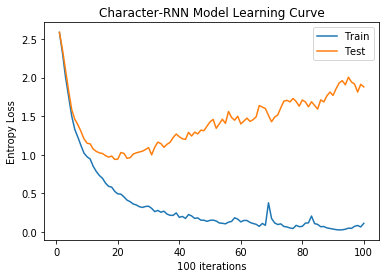

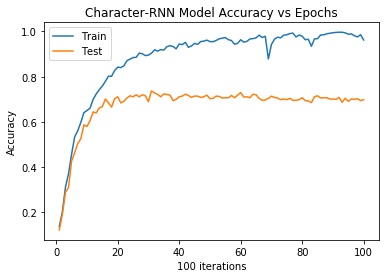

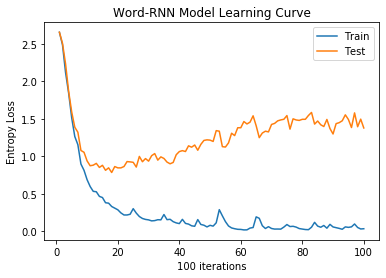

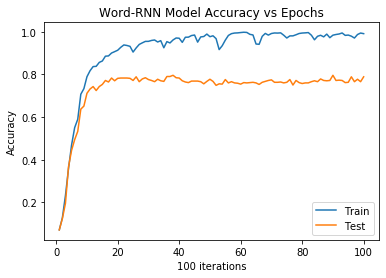

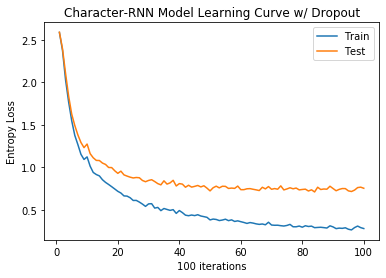

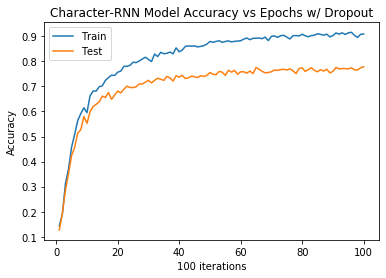

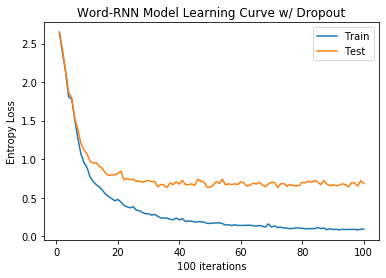

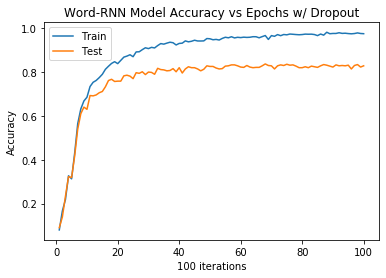

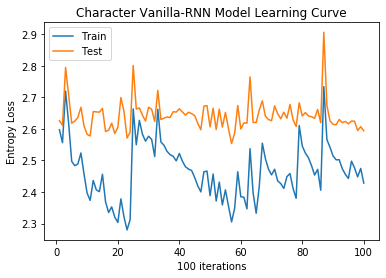

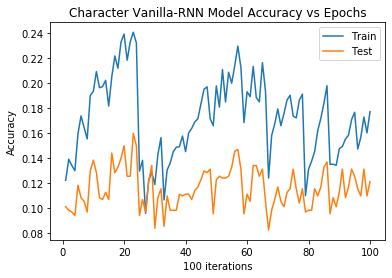

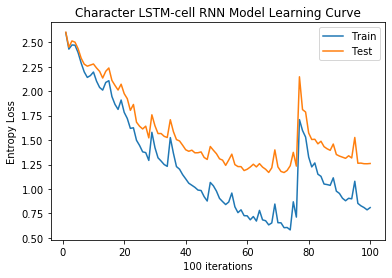

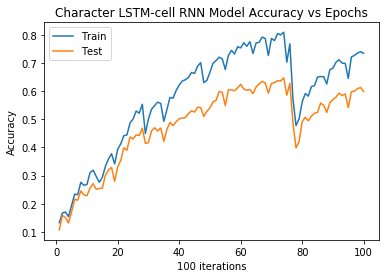

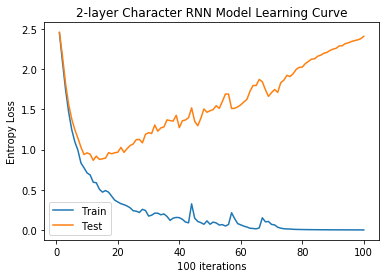

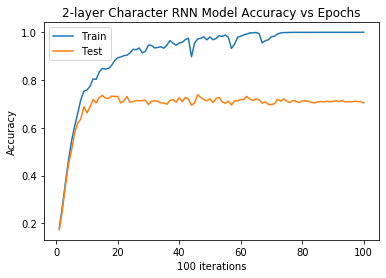

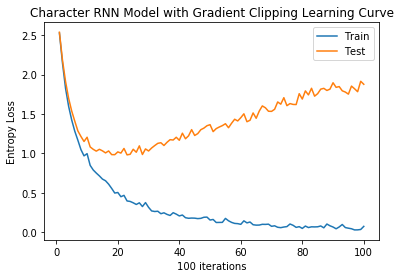

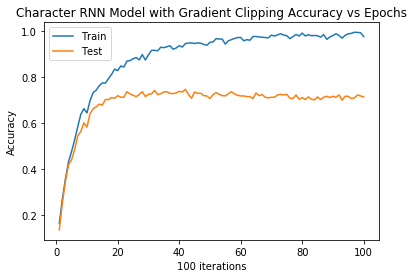

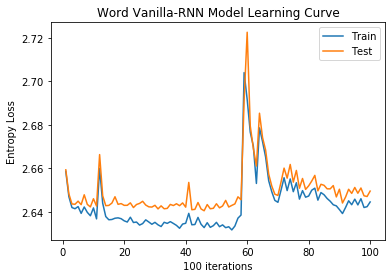

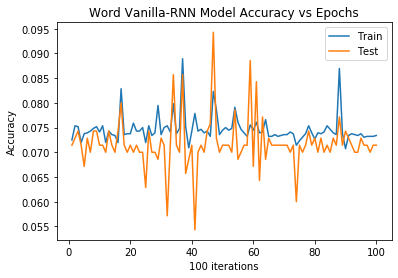

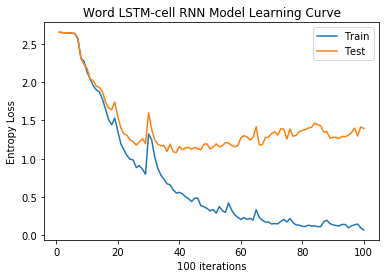

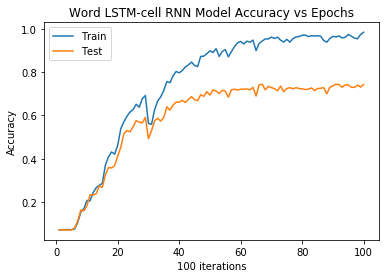

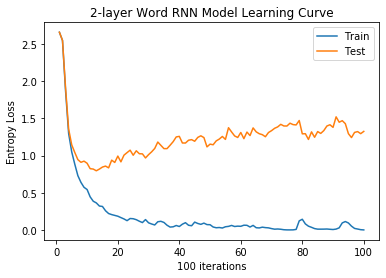

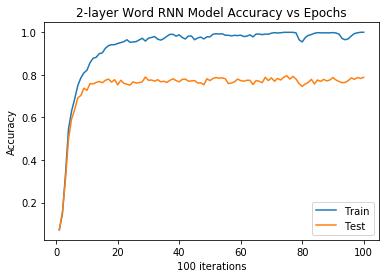

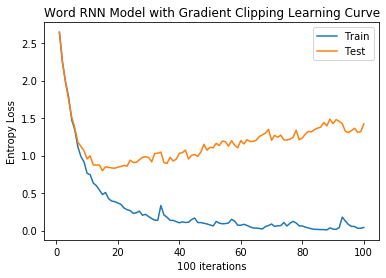

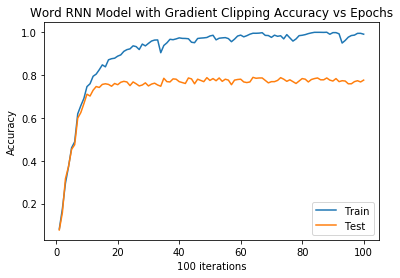

In [7]:
main()